In [1]:
%pip install numpy
%pip install tensorflow
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [48]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalMaxPooling2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, RandomFlip, RandomRotation, RandomZoom
from keras.callbacks import EarlyStopping
from keras import regularizers, Input
from keras.models import Model

# from keras import layers, models, callbacks
# from keras.optimizers import Adam

import matplotlib.pyplot as plt
import matplotlib.style as sty

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import tensorflow as tf
import itertools


import random as rn

In [3]:
#configuraes escolhidas para trreinamento
batch_size = 64
num_classes = 10
epochs = 50

#cada imagem do CIFAS10 tem o tamanho de 32 x 32 pixels
img_rows, img_cols = 32, 32

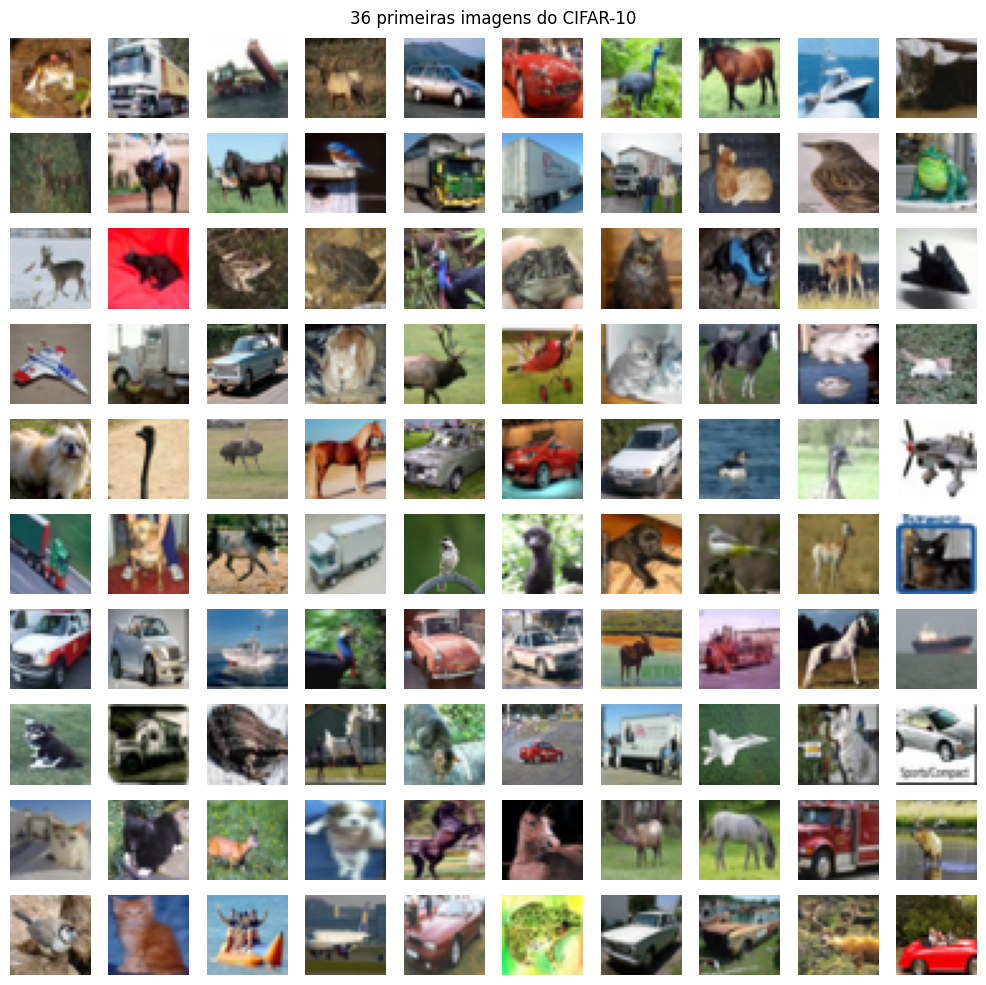

In [12]:
# carregando imagens e plotando alguns exemplso
from tensorflow.keras.utils import to_categorical

input_shape = (32, 32, 3)
# já tem shape (32,32,3)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# one-hot
# prepara os rótulos para a função de perda e métricas de classificação.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# normalizar
# coloca os pixels em uma faixa apropriada para treinar de forma estável e rápida.
# 0→0.0 e 255→1.0
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# plotar as 36 primeiras
fig, axes = plt.subplots(10, 10, figsize=(10,10))
for row in range(10):
    for col in range(10):
        idx = row*10 + col
        axes[row, col].imshow(x_train[idx])
        axes[row, col].axis('off')
fig.suptitle('36 primeiras imagens do CIFAR-10')
plt.tight_layout()
plt.show()



In [14]:
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [49]:
def cnn_with_augmentation(input_shape=(32,32,3), num_classes=10):
    # 1) Definir o estágio de augmentação
    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.1),   # ±10% de rotação
        RandomZoom(0.1)        # zoom de até 10%
    ], name="data_augmentation")
    
    # 2) Entrada
    inputs = Input(shape=input_shape)
    
    # 3) Aplicar augmentations só no treino
    x = data_augmentation(inputs)
    
    # 4) Blocos convolucionais (Conv→BN→ReLU→Dropout→Pool)
    # Bloco 1
    x = Conv2D(32, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D()(x)
    
    # Bloco 2
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D()(x)
    
    # Bloco 3
    x = Conv2D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D()(x)
    
    # 5) Pooling global ou flatten
    x = GlobalMaxPooling2D()(x)
    
    # 6) Camadas densas finais
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # 7) Monta o modelo
    model = Model(inputs, outputs, name="cnn_with_aug")
    return model

In [ ]:
def cnn(input_shape=input_shape, num_classes=10, pool='flatten'):
  model = Sequential()

  #  CNN em “três estágios” de convolução + pooling para extrair 
  # representações progressivamente mais abstratas, e em seguida camadas 
  # densas para mapear essas representações em classificações.

  # blocos 1, 2, 3 para aprendizado da representacao

  # 1
  # Conv2D(32, (3,3), …): aprende 32 filtros 3×3 sobre a entrada; 
  # padding='same' mantém as dimensões espaciais (32×32).
  # activation='relu': aplica ReLU, que ajuda a modelar não-linearidades.
  # Dropout(0.3): “desliga” aleatoriamente 30% dos neurônios para evitar overfitting.
  # MaxPooling2D(2×2): reduz pela metade altura e largura (e.g. de 32×32 para 16×16), mantendo o filtro mais forte em cada região.
  
  model.add(Conv2D(32, (3,3), padding='same'
                      , input_shape=input_shape
                      , kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
  
  # BatchNormalization() após cada convolução, antes da ReLU: 
  # estabiliza a distribuição das ativações, acelera e regulariza o treino.
  model.add(BatchNormalization())
  # Activation('relu') separada da Conv2D, seguindo o padrão Conv→BN→ReLU.
  model.add(Activation('relu'))
  
  model.add(Conv2D(32, (3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Dropout(0.3))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # 2
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.3))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # 3
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.3))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # camadas densas
  # parte totalmente conectada
  # Flatten(): “desenrola” o volume de ativação (por exemplo, 4×4×128 → 2048 neurônios).
  # GlobalMaxPooling2D(): toma o máximo de cada mapa de ativação, resultando em 128 valores fixos (um por filtro), independente da dimensão espacial.
  if pool == 'flatten': model.add(Flatten())
  else: model.add(GlobalMaxPooling2D())
  
  # Dense(512, relu): camada oculta com 512 neurônios para aprender combinações de características extraídas.
  model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
  model.add(Dropout(0.2))
  model.add(Dense(num_classes, activation='softmax',))

  return model

In [92]:
# mc=tf.keras.callbacks.ModelCheckpoint(
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True,
#     verbose=1)

rlr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,      # reduz LR para LR * 0.5
    patience=15,
    verbose=1
)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

In [63]:
# Plotar a matrix de confusão
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation = 'nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")

  print(cm)

  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j, i, cm[i,j], horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [64]:
def plot_grafico_historico(results):
    # Plotar o grafico do histórico de evolução do treinamento
    #sty.use('seaborn-whitegrid')
    #style.use('seaborn-whitegrid')
    plt.plot(results.history['accuracy'],'k--')
    plt.plot(results.history['val_accuracy'],'k')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plota o grafico do histórico de evolução da taxa de perda da rede
    plt.plot(results.history['loss'],'k--')
    plt.plot(results.history['val_loss'],'k')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()


### cnn com augmentation

In [65]:
model_aug = cnn_with_augmentation()
model_aug.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

model_aug.summary()

Model: "cnn_with_aug"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 359,978 (1.37 MB)

 Trainable params: 359,082 (1.37 MB)

 Non-trainable params: 896 (3.50 KB)

In [67]:
# Treinar a CNN
# Uso do ModelCheckPoint para salvar o melhor modelo
# ao longo das épocas de treinamento
fp_cnn_aug='./checkpoints/bestmodel_cnn_aug.keras'
mc_cnn_aug=tf.keras.callbacks.ModelCheckpoint(
    filepath=fp_cnn_aug,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

# Treinamento do modelo usando 20% da base de treinamento como validação
results_cnn_aug=model_aug.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_split=0.2,
                  callbacks=[mc_cnn_aug, rlr, es])

# Carregando o melhor model salvo em disco
model_aug.load_weights(fp_cnn_aug)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3420 - loss: 1.9225
Epoch 1: val_accuracy improved from -inf to 0.32360, saving model to ./checkpoints/bestmodel_cnn_aug.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 102ms/step - accuracy: 0.3422 - loss: 1.9220 - val_accuracy: 0.3236 - val_loss: 1.8174 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5324 - loss: 1.3007
Epoch 2: val_accuracy improved from 0.32360 to 0.49730, saving model to ./checkpoints/bestmodel_cnn_aug.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 99ms/step - accuracy: 0.5324 - loss: 1.3006 - val_accuracy: 0.4973 - val_loss: 1.4327 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5852 - loss: 1.1565
Epoch 3: val_accuracy improved from 0.49730 to 0.60760, saving model to ./checkpoints/bestmodel_cnn_aug.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 101ms/step - accuracy: 0.5853 - loss: 1.1564 - val_accuracy: 0.6076 - val_loss: 1.1789 - lea

In [68]:
score_aug = model_aug.evaluate(x_test, y_test, verbose=0)
print("Test loss: ", score_aug[0])
print('Test accuracy:', score_aug[1])

Test loss:  0.5847644209861755
Test accuracy: 0.8016999959945679


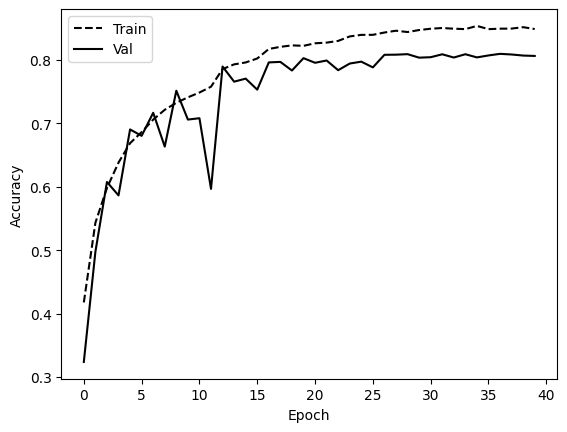

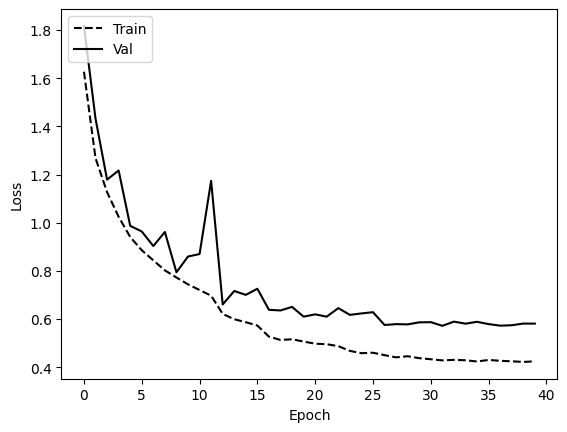

In [69]:
plot_grafico_historico(results_cnn_aug)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Confusion matrix, without normalization
[[807   9  54  19  23   0  18   5  47  18]
 [  7 877   2   5   0   0  25   1  19  64]
 [ 34   0 784  11  63  15  86   6   1   0]
 [  8   0  50 659  59  43 149  13  12   7]
 [  7   0  37  23 830   3  90   5   4   1]
 [  2   1  44 147  61 602 118  20   3   2]
 [  3   0  13  17   8   1 951   2   2   3]
 [  7   0  26  28 144  11  31 747   1   5]
 [ 38   3   6   6   9   0  23   0 905  10]
 [ 25  32   7  17   8   1  30   6  19 855]]


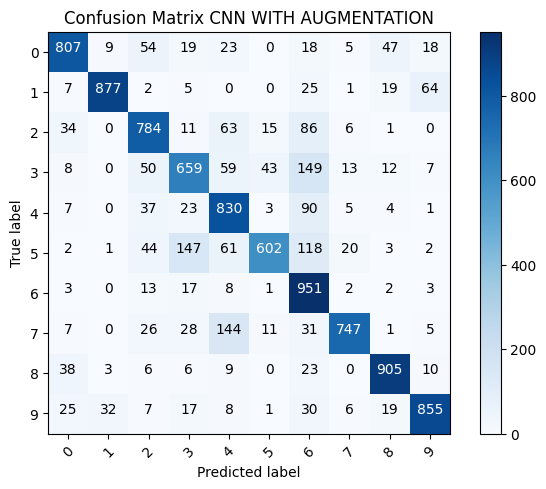

In [70]:
# Predição da CNN
y_predict=np.argmax(model_aug.predict(x_test), axis=1)

# Preparar Matriz de Confusão
cm_aug=confusion_matrix(np.argmax(y_test, axis=1), y_predict)
# Chamada da matriz confusão
cm_plot_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm_aug, cm_plot_labels, title= 'Confusion Matrix CNN WITH AUGMENTATION')


### cnn basica

In [71]:
model = cnn()
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

model.summary()

/home/philipe.hfransozi/Downloads/atividade_3/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 8, 8, 128)      │             

 Total params: 1,343,018 (5.12 MB)

 Trainable params: 1,342,122 (5.12 MB)

 Non-trainable params: 896 (3.50 KB)

In [72]:
# Treinar a CNN
fp_cnn_basica='./checkpoints/bestmodel_cnn_basica.keras'
mc_cnn_basica=tf.keras.callbacks.ModelCheckpoint(
    filepath=fp_cnn_basica,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

# Treinamento do modelo usando 20% da base de treinamento como validação
results_cnn_basica=model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_split=0.2,
                  callbacks=[mc_cnn_basica, rlr, es])

# Carregando o melhor model salvo em disco
model.load_weights(fp_cnn_basica)


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.3338 - loss: 2.1749
Epoch 1: val_accuracy improved from -inf to 0.37210, saving model to ./checkpoints/bestmodel_cnn_basica.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 103ms/step - accuracy: 0.3339 - loss: 2.1740 - val_accuracy: 0.3721 - val_loss: 1.7947 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5933 - loss: 1.1307
Epoch 2: val_accuracy improved from 0.37210 to 0.58690, saving model to ./checkpoints/bestmodel_cnn_basica.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.5933 - loss: 1.1306 - val_accuracy: 0.5869 - val_loss: 1.1527 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6845 - loss: 0.8980
Epoch 3: val_accuracy improved from 0.58690 to 0.63860, saving model to ./checkpoints/bestmodel_cnn_basica.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 103ms/step - accuracy: 0.6846 - loss: 0.8980 - val_accuracy: 0.6386 - val_loss: 1

In [73]:
score_cnn_basica = model.evaluate(x_test, y_test, verbose=0)
print("Test loss: ", score_cnn_basica[0])
print('Test accuracy:', score_cnn_basica[1])

Test loss:  0.6764721870422363
Test accuracy: 0.7706000208854675


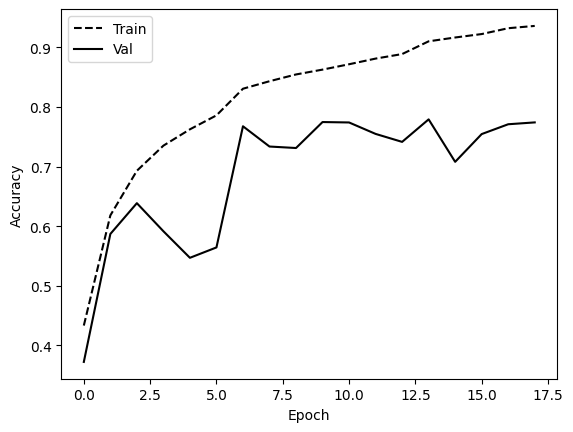

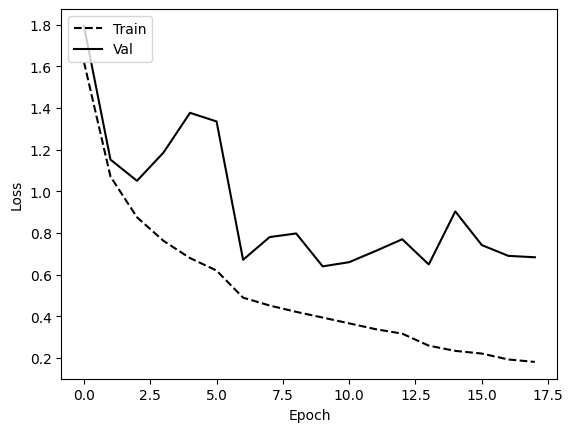

In [74]:
plot_grafico_historico(results_cnn_basica)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
Confusion matrix, without normalization
[[819   0  62  14  23   2  21   1  47  11]
 [ 27 785   7   5   2   3  31   0  60  80]
 [ 34   0 815  15  41  15  75   1   4   0]
 [ 13   0  95 604  68  49 157   4   7   3]
 [  7   0  89  21 811   4  65   2   1   0]
 [  7   0  78 179  56 559 112   6   3   0]
 [  3   0  28  11  10   0 946   1   1   0]
 [ 13   0  62  46 199  34  28 614   1   3]
 [ 26   2  15   6   5   1  22   0 919   4]
 [ 23  13  10  11   9   1  39   3  57 834]]


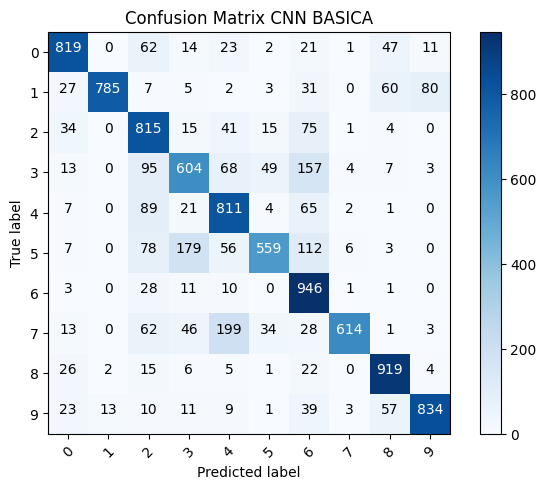

In [75]:
# Predição da CNN
y_predict=np.argmax(model.predict(x_test), axis=1)

# Preparar Matriz de Confusão
cm_cnn_basica=confusion_matrix(np.argmax(y_test, axis=1), y_predict)

# Chamada da matriz confusão
cm_plot_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm_cnn_basica, cm_plot_labels, title= 'Confusion Matrix CNN BASICA')

### cnn basica com global +  NADAM OPTIMIZER

In [93]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.5,
    staircase=True  # if False, decays continuously
)

model_cnn_basica_global_nadam = cnn(pool='global')
model_cnn_basica_global_nadam.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Nadam(learning_rate=lr_schedule), metrics=['accuracy'])

model_cnn_basica_global_nadam.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_96 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_72 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_73 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_74 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_75 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_76 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_77 (Activation)      │ (None, 8, 8, 128)      │             

 Total params: 359,978 (1.37 MB)

 Trainable params: 359,082 (1.37 MB)

 Non-trainable params: 896 (3.50 KB)

In [95]:
# Treinar a CNN
fp_cnn_basica_global_nadam='./checkpoints/bestmodel_cnn_basica_global_nadam.keras'
mc_cnn_basica_global_nadam=tf.keras.callbacks.ModelCheckpoint(
    filepath=fp_cnn_basica_global_nadam,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

# Treinamento do modelo usando 20% da base de treinamento como validação
results_cnn_basica_global_nadam=model_cnn_basica_global_nadam.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_split=0.2,
                  callbacks=[mc_cnn_basica_global_nadam, es])

# Carregando o melhor model salvo em disco
model_cnn_basica_global_nadam.load_weights(fp_cnn_basica_global_nadam)


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9639 - loss: 0.1057
Epoch 1: val_accuracy improved from -inf to 0.80170, saving model to ./checkpoints/bestmodel_cnn_basica_global_nadam.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 0.9639 - loss: 0.1057 - val_accuracy: 0.8017 - val_loss: 0.6141
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9652 - loss: 0.0996
Epoch 2: val_accuracy improved from 0.80170 to 0.80410, saving model to ./checkpoints/bestmodel_cnn_basica_global_nadam.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 92ms/step - accuracy: 0.9652 - loss: 0.0996 - val_accuracy: 0.8041 - val_loss: 0.6254
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9649 - loss: 0.1020
Epoch 3: val_accuracy improved from 0.80410 to 0.80720, saving model to ./checkpoints/bestmodel_cnn_basica_global_nadam.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 92ms/step - accuracy: 0.9649 - loss: 0.1020 - val_accuracy: 0.8072 - val_loss: 0.6272
Epoch 4

In [96]:
score_cnn_basica_global_nadam = model_cnn_basica_global_nadam.evaluate(x_test, y_test, verbose=0)
print("Test loss: ", score_cnn_basica_global_nadam[0])
print('Test accuracy:', score_cnn_basica_global_nadam[1])

Test loss:  0.5529602766036987
Test accuracy: 0.8360000252723694


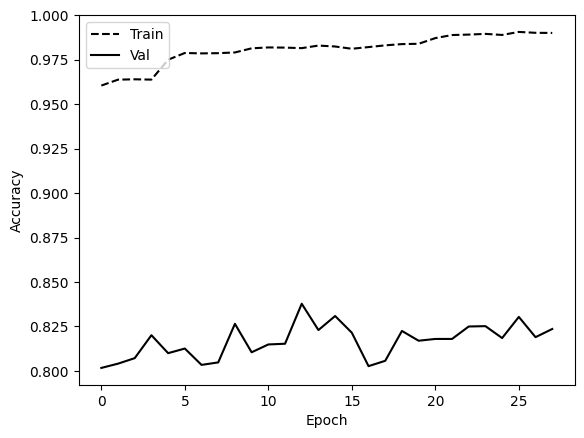

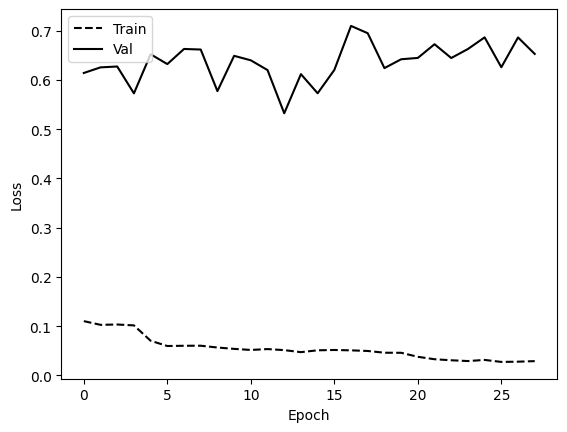

In [97]:
plot_grafico_historico(results_cnn_basica_global_nadam)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Confusion matrix, without normalization
[[821   3  24  32  24   3  18   3  51  21]
 [  6 861   2   8   6   1  35   1  25  55]
 [ 52   0 684  80  66  31  76   5   5   1]
 [  4   0  10 809  51  49  66   5   4   2]
 [  5   0  15  45 893  10  29   2   1   0]
 [  7   0  12 213  37 685  36  10   0   0]
 [  3   0  13  40  16   6 918   2   2   0]
 [  8   0  13  79 109  23  15 748   2   3]
 [ 19   4   1  23   4   1  13   1 926   8]
 [ 14  17   7  16   7   1  27   1  25 885]]


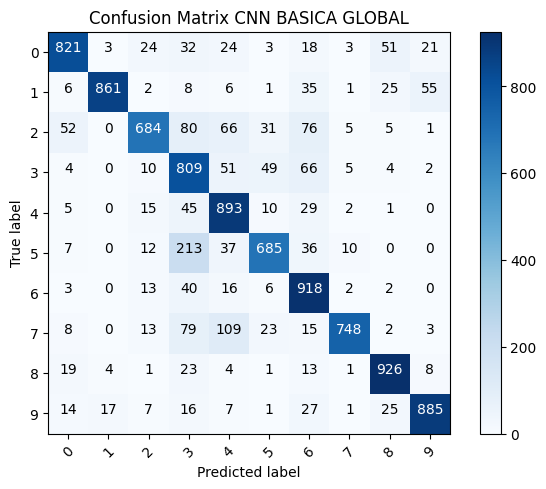

In [98]:
# Predição da CNN
y_predict_ndam=np.argmax(model_cnn_basica_global_nadam.predict(x_test), axis=1)

# Preparar Matriz de Confusão
cm_cnn_basica_global_ndam=confusion_matrix(np.argmax(y_test, axis=1), y_predict)

# Chamada da matriz confusão
cm_plot_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm_cnn_basica_global_ndam, cm_plot_labels, title= 'Confusion Matrix CNN BASICA GLOBAL')

### cnn basica com global

In [76]:
model_cnn_basica_global = cnn(pool='global')
model_cnn_basica_global.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

model_cnn_basica_global.summary()

/home/philipe.hfransozi/Downloads/atividade_3/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_44 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_46 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_47 (Activation)      │ (None, 8, 8, 128)      │             

 Total params: 359,978 (1.37 MB)

 Trainable params: 359,082 (1.37 MB)

 Non-trainable params: 896 (3.50 KB)

In [77]:
# Treinar a CNN
fp_cnn_basica_global='./checkpoints/bestmodel_cnn_basica_global.keras'
mc_cnn_basica_global=tf.keras.callbacks.ModelCheckpoint(
    filepath=fp_cnn_basica_global,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

# Treinamento do modelo usando 20% da base de treinamento como validação
results_cnn_basica_global=model_cnn_basica_global.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_split=0.2,
                  callbacks=[mc_cnn_basica_global, rlr, es])

# Carregando o melhor model salvo em disco
model_cnn_basica_global.load_weights(fp_cnn_basica_global)


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3827 - loss: 1.7527
Epoch 1: val_accuracy improved from -inf to 0.32540, saving model to ./checkpoints/bestmodel_cnn_basica_global.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 68s 99ms/step - accuracy: 0.3829 - loss: 1.7522 - val_accuracy: 0.3254 - val_loss: 1.8481 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6214 - loss: 1.0539
Epoch 2: val_accuracy improved from 0.32540 to 0.41680, saving model to ./checkpoints/bestmodel_cnn_basica_global.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - accuracy: 0.6214 - loss: 1.0538 - val_accuracy: 0.4168 - val_loss: 1.6105 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7026 - loss: 0.8353
Epoch 3: val_accuracy improved from 0.41680 to 0.65670, saving model to ./checkpoints/bestmodel_cnn_basica_global.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 99ms/step - accuracy: 0.7026 - loss: 0.8352 - val_accuracy: 0.6

In [78]:
score_cnn_basica_global = model_cnn_basica_global.evaluate(x_test, y_test, verbose=0)
print("Test loss: ", score_cnn_basica_global[0])
print('Test accuracy:', score_cnn_basica_global[1])

Test loss:  0.48019522428512573
Test accuracy: 0.840399980545044


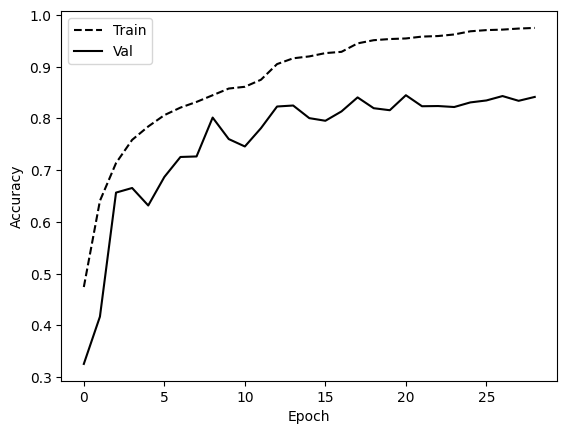

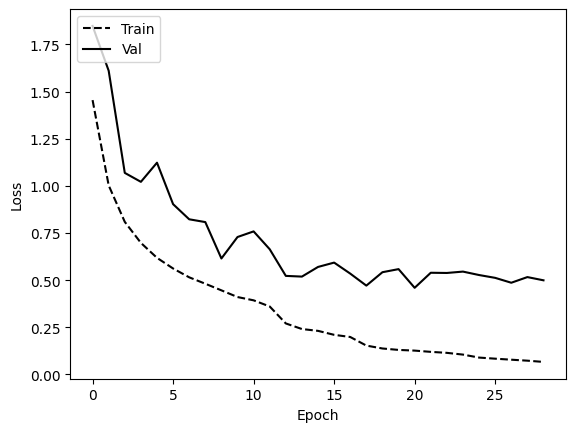

In [79]:
plot_grafico_historico(results_cnn_basica_global)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Confusion matrix, without normalization
[[904   3  26  10  19   2  13   6  12   5]
 [ 24 858   8   8   4   6  16   2  12  62]
 [ 48   0 797  29  62  27  32   3   2   0]
 [ 12   0  62 706  63  86  50  14   4   3]
 [ 10   0  32  25 892  11  22   8   0   0]
 [  3   0  37 143  37 747  16  17   0   0]
 [  3   0  40  28  13   5 907   3   1   0]
 [ 13   0  27  34  60  35   2 829   0   0]
 [ 54   8   9   9   6   4  10   6 889   5]
 [ 39  19  10  11   7   5   9   8  17 875]]


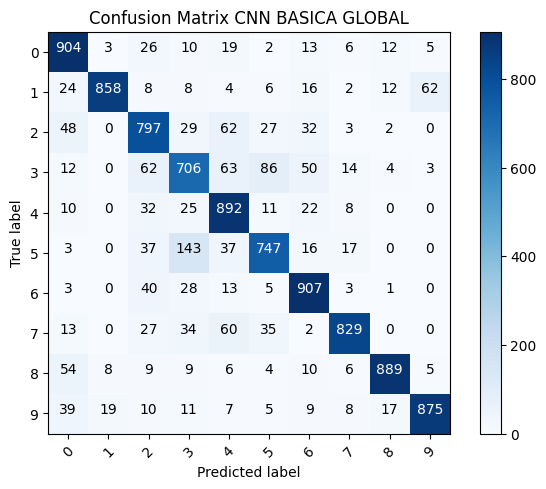

In [80]:
# Predição da CNN
y_predict=np.argmax(model_cnn_basica_global.predict(x_test), axis=1)

# Preparar Matriz de Confusão
cm_cnn_basica_global=confusion_matrix(np.argmax(y_test, axis=1), y_predict)

# Chamada da matriz confusão
cm_plot_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm_cnn_basica_global, cm_plot_labels, title= 'Confusion Matrix CNN BASICA GLOBAL')

### cnn aug com global

In [81]:
model_cnn_aug_global = cnn(pool='global')
model_cnn_aug_global.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

model_cnn_aug_global.summary()

/home/philipe.hfransozi/Downloads/atividade_3/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_51 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_52 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_53 (Activation)      │ (None, 8, 8, 128)      │             

 Total params: 359,978 (1.37 MB)

 Trainable params: 359,082 (1.37 MB)

 Non-trainable params: 896 (3.50 KB)

In [82]:
# Treinar a CNN
fp_cnn_aug_global='./checkpoints/bestmodel_cnn_aug_global.keras'
mc_cnn_aug_global=tf.keras.callbacks.ModelCheckpoint(
    filepath=fp_cnn_aug_global,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

# Treinamento do modelo usando 20% da base de treinamento como validação
results_cnn_aug_global=model_cnn_aug_global.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_split=0.2,
                  callbacks=[mc_cnn_aug_global, rlr, es])

# Carregando o melhor model salvo em disco
model_cnn_aug_global.load_weights(fp_cnn_aug_global)


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3793 - loss: 1.7509
Epoch 1: val_accuracy improved from -inf to 0.31740, saving model to ./checkpoints/bestmodel_cnn_aug_global.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 99ms/step - accuracy: 0.3794 - loss: 1.7505 - val_accuracy: 0.3174 - val_loss: 1.8205 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6304 - loss: 1.0374
Epoch 2: val_accuracy improved from 0.31740 to 0.45790, saving model to ./checkpoints/bestmodel_cnn_aug_global.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 95ms/step - accuracy: 0.6304 - loss: 1.0373 - val_accuracy: 0.4579 - val_loss: 1.4732 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7147 - loss: 0.8105
Epoch 3: val_accuracy improved from 0.45790 to 0.64570, saving model to ./checkpoints/bestmodel_cnn_aug_global.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - accuracy: 0.7147 - loss: 0.8105 - val_accuracy: 0.6457 - val

In [83]:
score_cnn_aug_global = model_cnn_aug_global.evaluate(x_test, y_test, verbose=0)
print("Test loss: ", score_cnn_aug_global[0])
print('Test accuracy:', score_cnn_aug_global[1])

Test loss:  0.5182293653488159
Test accuracy: 0.8230000138282776


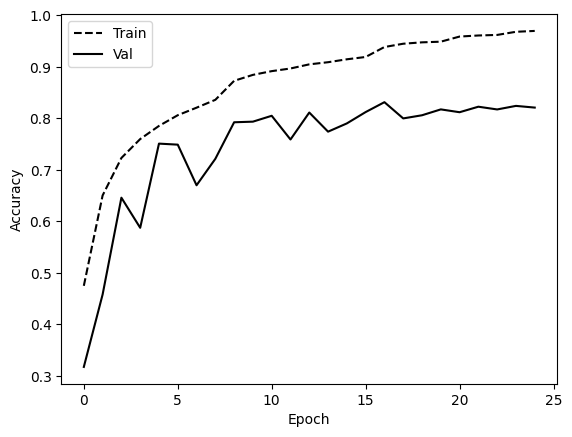

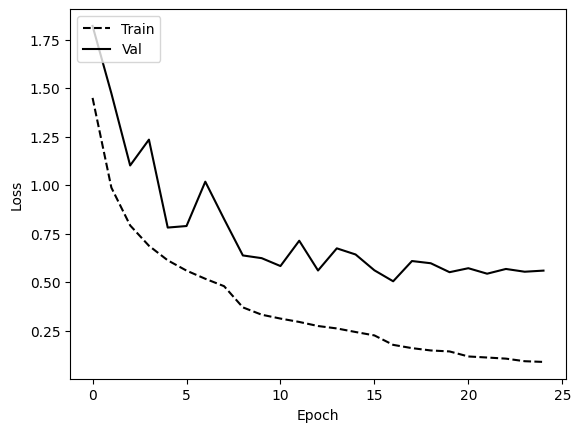

In [84]:
plot_grafico_historico(results_cnn_aug_global)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Confusion matrix, without normalization
[[821   3  24  32  24   3  18   3  51  21]
 [  6 861   2   8   6   1  35   1  25  55]
 [ 52   0 684  80  66  31  76   5   5   1]
 [  4   0  10 809  51  49  66   5   4   2]
 [  5   0  15  45 893  10  29   2   1   0]
 [  7   0  12 213  37 685  36  10   0   0]
 [  3   0  13  40  16   6 918   2   2   0]
 [  8   0  13  79 109  23  15 748   2   3]
 [ 19   4   1  23   4   1  13   1 926   8]
 [ 14  17   7  16   7   1  27   1  25 885]]


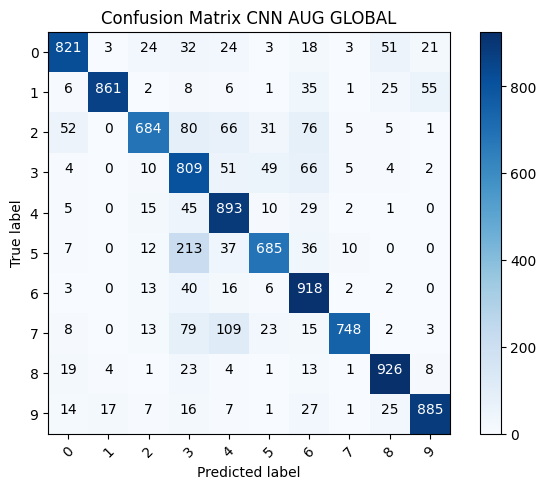

In [85]:
# Predição da CNN
y_predict=np.argmax(model_cnn_aug_global.predict(x_test), axis=1)

# Preparar Matriz de Confusão
cm_cnn_aug_global=confusion_matrix(np.argmax(y_test, axis=1), y_predict)

# Chamada da matriz confusão
cm_plot_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm_cnn_aug_global, cm_plot_labels, title= 'Confusion Matrix CNN AUG GLOBAL')